# __Accompanying notebook for: Velocity Measurements of Icy Powdered Rock and Implications for Seismic Resource Exploration on the Moon__

_Chance Amos, Kevin Cannon, Manika Prasad, Chris Dreyer_<br>
_Colorado School of Mines_<br>


## Load Libraries and Data

In [1]:
import rputils.rputils as rp
import rputils.rpwave as rwav
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import HTML
import json
from scipy import integrate, optimize

from decimal import Decimal
import matplotlib.ticker as mticker
def sci_format_short(x,lim):
    return '{:.0e}'.format(x)
major_formatter1 = mticker.FuncFormatter(sci_format_short)
def sci_format_alt(x,lim):
    return '{:.1e}'.format(Decimal(x))
major_formatter2 = mticker.FuncFormatter(sci_format_alt)

## Define consistent color to use for the 4 pressure steps
pres_colors = ["dimgray", "brown", "royalblue", "darkgoldenrod"]
pressures = [0.000005, 0.00003, 0.000055, 0.00008] # in GPa

## Define colors for the ice concentrations
ice_colors = ["steelblue", "deepskyblue", "mediumblue", "blueviolet"]
ice_percs = [0.02, 0.05, 0.1, 0.2]

In [2]:
"""
Load all data
"""

## Mineral data
with open("../data/mineral_data.txt", "r") as f:
    min_dict = json.load(f)

## Particle size distribution
data_path = "../data/grain_size/LHT-1g_ParticleSize.txt"
particle_data = np.genfromtxt(data_path, skip_header=1)

## Ice elastic constants
data_path = "../data/Neumeier_ice_elastic_constants.txt"
ice_elastic_constants = np.genfromtxt(data_path, skip_header=1)

## Velocity data
## Data loads as [sample number, (vp, bulk density, porosity)]
data_p_0i = np.genfromtxt("../data/velocity_picks/0_ice_vp.txt", skip_header=1)
data_p_1i = np.genfromtxt("../data/velocity_picks/1_ice_vp.txt", skip_header=1)
data_p_2i = np.genfromtxt("../data/velocity_picks/2_ice_vp.txt", skip_header=1)
data_p_5i = np.genfromtxt("../data/velocity_picks/5_ice_vp.txt", skip_header=1)
data_p_10i = np.genfromtxt("../data/velocity_picks/10_ice_vp.txt", skip_header=1)
data_p_20i = np.genfromtxt("../data/velocity_picks/20_ice_vp.txt", skip_header=1)

data_s_0i = np.genfromtxt("../data/velocity_picks/0_ice_vs.txt", skip_header=1)
data_s_2i = np.genfromtxt("../data/velocity_picks/2_ice_vs.txt", skip_header=1)
data_s_5i = np.genfromtxt("../data/velocity_picks/5_ice_vs.txt", skip_header=1)
data_s_10i = np.genfromtxt("../data/velocity_picks/10_ice_vs.txt", skip_header=1)
data_s_20i = np.genfromtxt("../data/velocity_picks/20_ice_vs.txt", skip_header=1)

## Cemented samples
data_p_5i_cem = np.genfromtxt("../data/velocity_picks/5_ice_vp_cemented.txt", skip_header=1)
data_p_10i_cem = np.genfromtxt("../data/velocity_picks/10_ice_vp_cemented.txt", skip_header=1)
cem_por_cutoff = 0.55
data_p_5i_cem = data_p_5i_cem[data_p_5i_cem[:,2]<cem_por_cutoff]
data_p_10i_cem = data_p_10i_cem[data_p_10i_cem[:,2]<cem_por_cutoff]


## Pressure-velocity data
## Data loads as [sample number, (vp, bulk density, porosity, pressure (MPa))]
data_pressure_p_0i = np.genfromtxt("../data/velocity_picks/0_ice_vp_pressure.txt", skip_header=1)
data_pressure_p_5i = np.genfromtxt("../data/velocity_picks/5_ice_vp_pressure.txt", skip_header=1)
data_pressure_p_10i = np.genfromtxt("../data/velocity_picks/10_ice_vp_pressure.txt", skip_header=1)

data_pressure_s_0i = np.genfromtxt("../data/velocity_picks/0_ice_vs_pressure.txt", skip_header=1)
data_pressure_s_5i = np.genfromtxt("../data/velocity_picks/5_ice_vs_pressure.txt", skip_header=1)
data_pressure_s_10i = np.genfromtxt("../data/velocity_picks/10_ice_vs_pressure.txt", skip_header=1)

pres_step_0_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p_0i = data_pressure_p_0i[np.where(data_pressure_p_0i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p_5i = data_pressure_p_5i[np.where(data_pressure_p_5i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p_10i = data_pressure_p_10i[np.where(data_pressure_p_10i[:,-1]==round(pressures[3]*1000,3))]

pres_step_0_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s_0i = data_pressure_s_0i[np.where(data_pressure_s_0i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s_5i = data_pressure_s_5i[np.where(data_pressure_s_5i[:,-1]==round(pressures[3]*1000,3))]
pres_step_0_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s_10i = data_pressure_s_10i[np.where(data_pressure_s_10i[:,-1]==round(pressures[3]*1000,3))]


## Data Plots

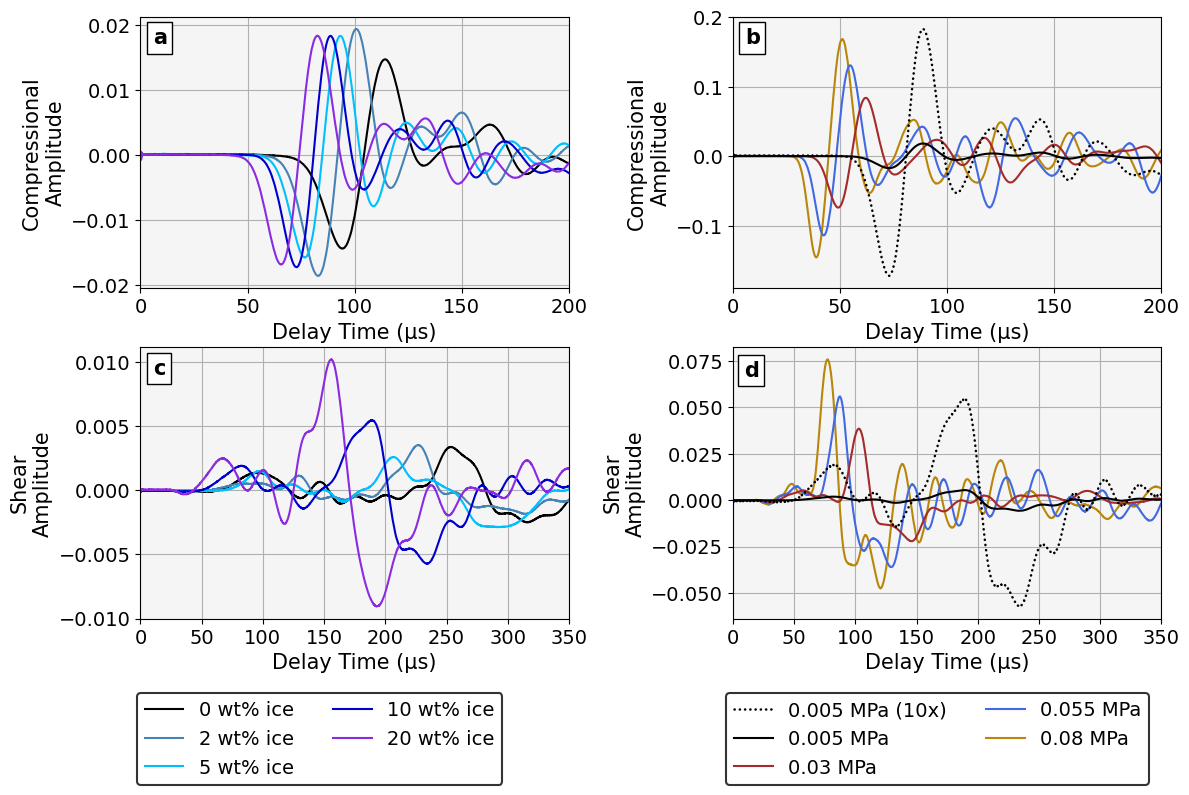

In [3]:
"""
Plot examples of raw waveforms
"""

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Data paths

p0_0i_path = "../data/raw_waves/P_waves/0_ice_granular/LightPack/16_P_0i_13-64mm_18-49g_P000_0000.asc"
p0_2i_path = "../data/raw_waves/P_waves/2_ice_granular/LightPack/6_P_2i_13-75mm_18-95g_P000_0000.asc"
p0_5i_path = "../data/raw_waves/P_waves/5_ice_granular/LightPack/10_P_5i_13-8mm_16-79g_P000_0000.asc"
p0_20i_path = "../data/raw_waves/P_waves/20_ice_granular/LightPack/18_P_20i_13-63mm_12-51g_P000_0000.asc"
p0_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_P_10i_13-9mm_16-9g_P000_0000.asc"
p1_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_2kg_P_10i_13-38mm_16-9g_P000_0000.asc"
p2_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_4kg_P_10i_13-25mm_16-9g_P000_0000.asc"
p3_10i_path = "../data/raw_waves/P_waves/10_ice_granular/Pressure/1_6kg_P_10i_13-2mm_16-9g_P000_0000.asc"

s0_0i_path = "../data/raw_waves/S_waves/0_ice_granular/LightPack/8_S_0i_16-44mm_22-42g_P000_0000.asc"
s0_2i_path = "../data/raw_waves/S_waves/2_ice_granular/LightPack/8_S_2i_16-86mm_22-07g_P000_0000.asc"
s0_5i_path = "../data/raw_waves/S_waves/5_ice_granular/LightPack/2_S_5i_16-84mm_20-97g_P000_0000.asc"
s0_20i_path = "../data/raw_waves/S_waves/20_ice_granular/LightPack/3_S_20i_16-62mm_15-98g_P000_0000.asc"
s0_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_S_10i_16-9mm_19-35g_P000_0000.asc"
s1_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_2kg_S_10i_16-15mm_19-35g_P000_0000.asc"
s2_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_4kg_S_10i_16-1mm_19-35g_P000_0000.asc"
s3_10i_path = "../data/raw_waves/S_waves/10_ice_granular/Pressure/5_6kg_S_10i_16-0mm_19-35g_P000_0000.asc"


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Load saved waveforms
wavep0_0i, wavep0_0i_header = rwav.load_waveform(p0_0i_path, return_header=True)
wavep0_2i, wavep0_2i_header = rwav.load_waveform(p0_2i_path, return_header=True)
wavep0_5i, wavep0_5i_header = rwav.load_waveform(p0_5i_path, return_header=True)
wavep0_20i, wavep0_20i_header = rwav.load_waveform(p0_20i_path, return_header=True)
wavep0_10i, wavep0_10i_header = rwav.load_waveform(p0_10i_path, return_header=True)
wavep1_10i, wavep1_10i_header = rwav.load_waveform(p1_10i_path, return_header=True)
wavep2_10i, wavep2_10i_header = rwav.load_waveform(p2_10i_path, return_header=True)
wavep3_10i, wavep3_10i_header = rwav.load_waveform(p3_10i_path, return_header=True)

waves0_0i, waves0_0i_header = rwav.load_waveform(s0_0i_path, return_header=True)
waves0_2i, waves0_2i_header = rwav.load_waveform(s0_2i_path, return_header=True)
waves0_5i, waves0_5i_header = rwav.load_waveform(s0_5i_path, return_header=True)
waves0_20i, waves0_20i_header = rwav.load_waveform(s0_20i_path, return_header=True)
waves0_10i, waves0_10i_header = rwav.load_waveform(s0_10i_path, return_header=True)
waves1_10i, waves1_10i_header = rwav.load_waveform(s1_10i_path, return_header=True)
waves2_10i, waves2_10i_header = rwav.load_waveform(s2_10i_path, return_header=True)
waves3_10i, waves3_10i_header = rwav.load_waveform(s3_10i_path, return_header=True)

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## P DATA
## Grab time values, optionally smooth amplitudes

wavep0_0i_time = wavep0_0i[0,:] / 1e3
wavep0_2i_time = wavep0_2i[0,:] / 1e3
wavep0_5i_time = wavep0_5i[0,:] / 1e3
wavep0_20i_time = wavep0_20i[0,:] / 1e3
wavep0_10i_time = wavep0_10i[0,:] / 1e3
wavep1_10i_time = wavep1_10i[0,:] / 1e3
wavep2_10i_time = wavep2_10i[0,:] / 1e3
wavep3_10i_time = wavep3_10i[0,:] / 1e3
    
wavep0_0i_amp = wavep0_0i[1,:]
wavep0_2i_amp = wavep0_2i[1,:]
wavep0_5i_amp = wavep0_5i[1,:]
wavep0_20i_amp = wavep0_20i[1,:]
wavep0_10i_amp = wavep0_10i[1,:]
wavep1_10i_amp = wavep1_10i[1,:]
wavep2_10i_amp = wavep2_10i[1,:]
wavep3_10i_amp = wavep3_10i[1,:]


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## S DATA
## Grab time values, optionally smooth amplitudes

waves0_0i_time = waves0_0i[0,:] / 1e3
waves0_2i_time = waves0_2i[0,:] / 1e3
waves0_5i_time = waves0_5i[0,:] / 1e3
waves0_20i_time = waves0_20i[0,:] / 1e3
waves0_10i_time = waves0_10i[0,:] / 1e3
waves1_10i_time = waves1_10i[0,:] / 1e3
waves2_10i_time = waves2_10i[0,:] / 1e3
waves3_10i_time = waves3_10i[0,:] / 1e3
    
waves0_0i_amp = waves0_0i[1,:]
waves0_2i_amp = waves0_2i[1,:]
waves0_5i_amp = waves0_5i[1,:]
waves0_20i_amp = waves0_20i[1,:]
waves0_10i_amp = waves0_10i[1,:]
waves1_10i_amp = waves1_10i[1,:]
waves2_10i_amp = waves2_10i[1,:]
waves3_10i_amp = waves3_10i[1,:]
    
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## PLOTS

## Plot waveforms
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
xlims_p=(0, 200)
xlims_s=(0, 350)
amp_multiplier = 10


ax[0,0].plot(wavep0_0i_time, wavep0_0i_amp, label="0 wt% ice", color="black")
ax[0,0].plot(wavep0_2i_time, wavep0_2i_amp, label=str(round(ice_percs[0]*100))+" wt% ice", color=ice_colors[0])
ax[0,0].plot(wavep0_5i_time, wavep0_5i_amp, label=str(round(ice_percs[1]*100))+" wt% ice", color=ice_colors[1])
ax[0,0].plot(wavep0_10i_time, wavep0_10i_amp, label=str(round(ice_percs[2]*100))+" wt% ice", color=ice_colors[2])
ax[0,0].plot(wavep0_20i_time, wavep0_20i_amp, label=str(round(ice_percs[3]*100))+" wt% ice", color=ice_colors[3])
ax[0,0].grid("both")
ax[0,0].set(xlim=(xlims_p[0],xlims_p[1]),
          yscale="linear",
          facecolor="whitesmoke")
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].set_ylabel("Compressional\nAmplitude", fontsize=15)
ax[0,0].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[0,0].text(9, 0.018, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[1,0].plot(waves0_0i_time, waves0_0i_amp, label="0 wt% ice", color="black")
ax[1,0].plot(waves0_2i_time, waves0_2i_amp, label=str(round(ice_percs[0]*100))+" wt% ice", color=ice_colors[0])
ax[1,0].plot(waves0_5i_time, waves0_5i_amp, label=str(round(ice_percs[1]*100))+" wt% ice", color=ice_colors[1])
ax[1,0].plot(waves0_10i_time, waves0_10i_amp, label=str(round(ice_percs[2]*100))+" wt% ice", color=ice_colors[2])
ax[1,0].plot(waves0_20i_time, waves0_20i_amp, label=str(round(ice_percs[3]*100))+" wt% ice", color=ice_colors[3])
ax[1,0].grid("both")
ax[1,0].set(xlim=(xlims_s[0],xlims_s[1]),
          yscale="linear",
         facecolor="whitesmoke")
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].set_ylabel("Shear\nAmplitude", fontsize=15)
ax[1,0].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[1,0].text(15, 0.0095, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
handles, labels = ax[0,0].get_legend_handles_labels()
legend1 = fig.legend(handles, labels, bbox_to_anchor=(0.11, 0.0, 1., 1), ncols=2, 
           loc='lower left', fontsize=14)
legend1.get_frame().set_linewidth(1.5)
legend1.get_frame().set_edgecolor("black")



ax[0,1].plot(wavep3_10i_time, wavep3_10i_amp, label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3])
ax[0,1].plot(wavep2_10i_time, wavep2_10i_amp, label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2])
ax[0,1].plot(wavep1_10i_time, wavep1_10i_amp, label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1])
ax[0,1].plot(wavep0_10i_time, wavep0_10i_amp, label=str(round(pressures[0]*1000,3))+" MPa", color="black")
ax[0,1].plot(wavep0_10i_time, wavep0_10i_amp*amp_multiplier, label=str(round(pressures[0]*1000,3))+" MPa", color="black", 
           ls=(0, (0.1, 2)), lw=1.8, dash_capstyle = "round")
ax[0,1].grid("both")
ax[0,1].set(xlim=(xlims_p[0],xlims_p[1]),
          yscale="linear",
          facecolor="whitesmoke")
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].set_ylabel("Compressional\nAmplitude", fontsize=15)
ax[0,1].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[0,1].text(9, 0.17, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

ax[1,1].plot(waves3_10i_time, waves3_10i_amp, label=str(round(pressures[3]*1000,3))+" MPa", color=pres_colors[3])
ax[1,1].plot(waves2_10i_time, waves2_10i_amp, label=str(round(pressures[2]*1000,3))+" MPa", color=pres_colors[2])
ax[1,1].plot(waves1_10i_time, waves1_10i_amp, label=str(round(pressures[1]*1000,3))+" MPa", color=pres_colors[1])
ax[1,1].plot(waves0_10i_time, waves0_10i_amp, label=str(round(pressures[0]*1000,3))+" MPa", color="black")
ax[1,1].plot(waves0_10i_time, waves0_10i_amp*amp_multiplier, label=str(round(pressures[0]*1000,3))+" MPa (10x)", color="black", 
           ls=(0, (0.1, 2)), lw=1.8, dash_capstyle = "round")
ax[1,1].grid("both")
ax[1,1].set(xlim=(xlims_s[0],xlims_s[1]),
          yscale="linear",
         facecolor="whitesmoke")
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].set_ylabel("Shear\nAmplitude", fontsize=15)
ax[1,1].set_xlabel("Delay Time (\u03BCs)", fontsize=15)
ax[1,1].text(15, 0.07, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})


handles, labels = ax[1,1].get_legend_handles_labels()
legend2 = fig.legend(handles[::-1], labels[::-1], bbox_to_anchor=(-0.03, 0.0, 1., 1), ncols=2, 
           loc='lower right', fontsize=14)
legend2.get_frame().set_linewidth(1.5)
legend2.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)

plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/waveforms.jpg", dpi=1000, bbox_inches = "tight")

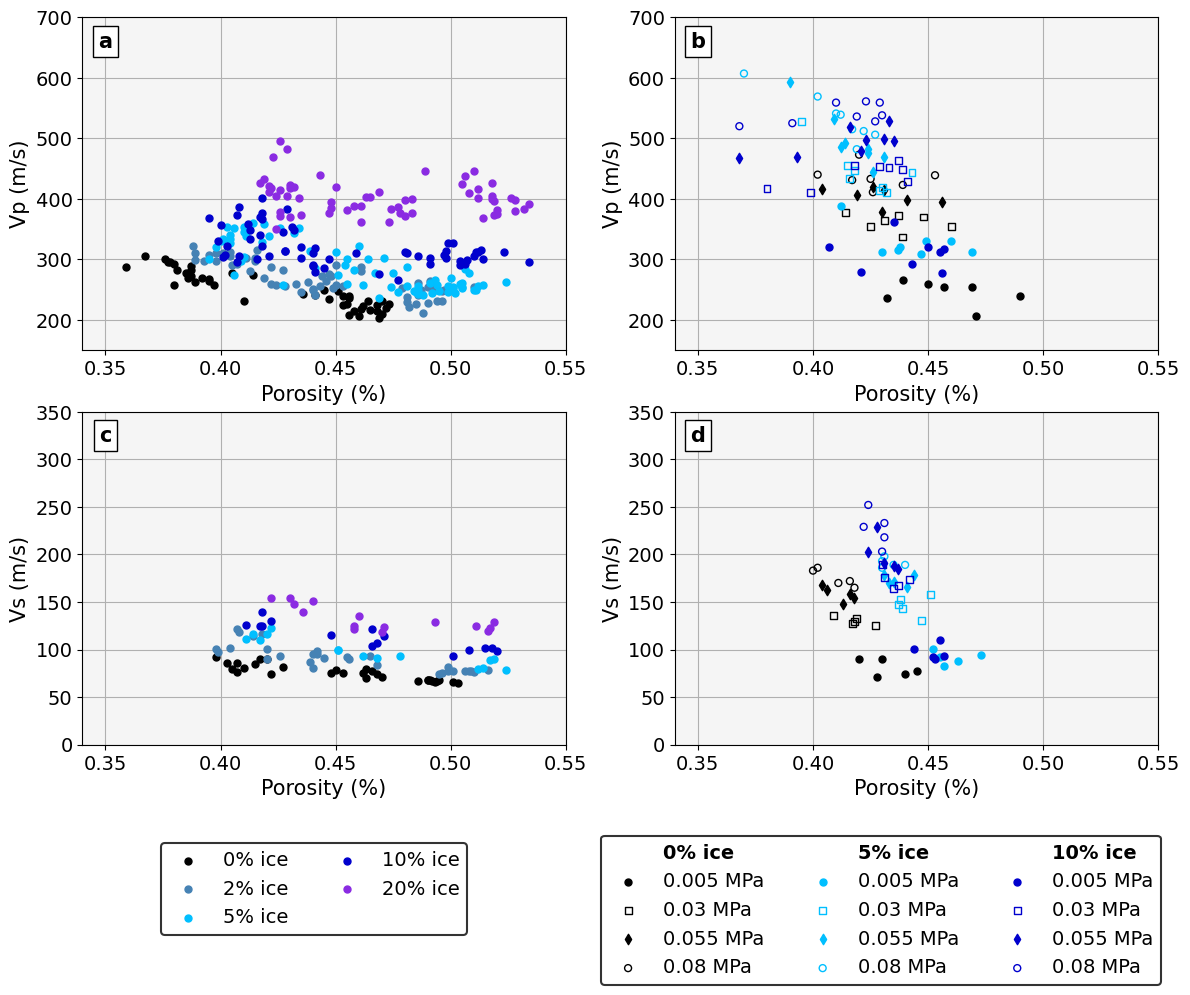

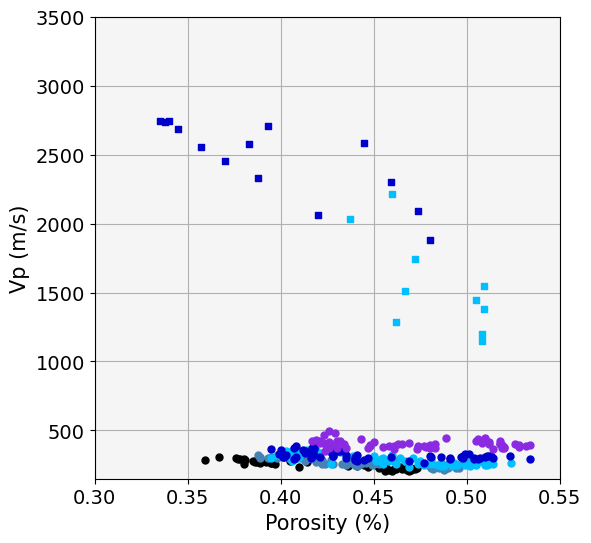

In [5]:
"""
Plot measured Vp and Vs data
"""

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
xlims = (0.34, 0.55)
dot_size = 25

ax[0,0].scatter(data_p_0i[:,2], data_p_0i[:,0], s=dot_size, label="0% ice", color="black")
ax[0,0].scatter(data_p_2i[:,2], data_p_2i[:,0], s=dot_size, label=str(round(ice_percs[0]*100))+"% ice", color=ice_colors[0])
ax[0,0].scatter(data_p_5i[:,2], data_p_5i[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", color=ice_colors[1])
ax[0,0].scatter(data_p_10i[:,2], data_p_10i[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", color=ice_colors[2])
ax[0,0].scatter(data_p_20i[:,2], data_p_20i[:,0], s=dot_size, label=str(round(ice_percs[3]*100))+"% ice", color=ice_colors[3])
ax[0,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].set_xlabel("Porosity (%)", fontsize=15)
ax[0,0].set_ylabel("Vp (m/s)", fontsize=15)
ax[0,0].tick_params(axis='both', labelsize=14)
ax[0,0].text(0.35, 660, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,0].grid("both")

ax[1,0].scatter(data_s_0i[:,2], data_s_0i[:,0], s=dot_size, label="0% ice", color="black")
ax[1,0].scatter(data_s_2i[:,2], data_s_2i[:,0], s=dot_size, label=str(round(ice_percs[0]*100))+"% ice", color=ice_colors[0])
ax[1,0].scatter(data_s_5i[:,2], data_s_5i[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", color=ice_colors[1])
ax[1,0].scatter(data_s_10i[:,2], data_s_10i[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", color=ice_colors[2])
ax[1,0].scatter(data_s_20i[:,2], data_s_20i[:,0], s=dot_size, label=str(round(ice_percs[3]*100))+"% ice", color=ice_colors[3])
ax[1,0].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,350),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].set_xlabel("Porosity (%)", fontsize=15)
ax[1,0].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,0].tick_params(axis='both', labelsize=14)
ax[1,0].text(0.35, 325, "c", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,0].grid("both")

handles, labels = ax[0,0].get_legend_handles_labels()
legend1 = fig.legend(handles, labels, bbox_to_anchor=(0.13, 0.05, 1., 1), ncols=2, 
           loc='lower left', fontsize=14)
legend1.get_frame().set_linewidth(1.5)
legend1.get_frame().set_edgecolor("black")


ax[0,1].scatter(pres_step_0_p_0i[:,2], pres_step_0_p_0i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_p_0i[:,2], pres_step_1_p_0i[:,0], s=dot_size, edgecolor="black", facecolor="none", marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_p_0i[:,2], pres_step_2_p_0i[:,0], s=dot_size+3, color="black", marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_p_0i[:,2], pres_step_3_p_0i[:,0], s=dot_size, edgecolor="black", facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_0_p_5i[:,2], pres_step_0_p_5i[:,0], s=dot_size, color=ice_colors[1],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_p_5i[:,2], pres_step_1_p_5i[:,0], s=dot_size, edgecolor=ice_colors[1], facecolor="none", marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_p_5i[:,2], pres_step_2_p_5i[:,0], s=dot_size+3, color=ice_colors[1], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_p_5i[:,2], pres_step_3_p_5i[:,0], s=dot_size, edgecolor=ice_colors[1], facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_0_p_10i[:,2], pres_step_0_p_10i[:,0], s=dot_size, color=ice_colors[2],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_1_p_10i[:,2], pres_step_1_p_10i[:,0], s=dot_size, edgecolor=ice_colors[2], facecolor="none", marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_2_p_10i[:,2], pres_step_2_p_10i[:,0], s=dot_size+3, color=ice_colors[2], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[0,1].scatter(pres_step_3_p_10i[:,2], pres_step_3_p_10i[:,0], s=dot_size, edgecolor=ice_colors[2], facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[0,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(150,700),
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].set_xlabel("Porosity (%)", fontsize=15)
ax[0,1].set_ylabel("Vp (m/s)", fontsize=15)
ax[0,1].tick_params(axis='both', labelsize=14)
ax[0,1].text(0.35, 660, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[0,1].grid("both")

ax[1,1].scatter(0,0, color="none", label="0% ice")
ax[1,1].scatter(pres_step_0_s_0i[:,2], pres_step_0_s_0i[:,0], s=dot_size, color="black",
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_0i[:,2], pres_step_1_s_0i[:,0], s=dot_size, edgecolor="black", facecolor="none", marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_0i[:,2], pres_step_2_s_0i[:,0], s=dot_size+3, color="black", marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_0i[:,2], pres_step_3_s_0i[:,0], s=dot_size, edgecolor="black", facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[1,1].scatter(0,0, color="none", label="5% ice")
ax[1,1].scatter(pres_step_0_s_5i[:,2], pres_step_0_s_5i[:,0], s=dot_size, color=ice_colors[1],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_5i[:,2], pres_step_1_s_5i[:,0], s=dot_size, edgecolor=ice_colors[1], facecolor="none", marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_5i[:,2], pres_step_2_s_5i[:,0], s=dot_size+3, color=ice_colors[1], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_5i[:,2], pres_step_3_s_5i[:,0], s=dot_size, edgecolor=ice_colors[1], facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[1,1].scatter(0,0, color="none", label="10% ice")
ax[1,1].scatter(pres_step_0_s_10i[:,2], pres_step_0_s_10i[:,0], s=dot_size, color=ice_colors[2],
             label=str(round(pressures[0]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_1_s_10i[:,2], pres_step_1_s_10i[:,0], s=dot_size, edgecolor=ice_colors[2], facecolor="none", marker="s",
             label=str(round(pressures[1]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_2_s_10i[:,2], pres_step_2_s_10i[:,0], s=dot_size+3, color=ice_colors[2], marker="d",
             label=str(round(pressures[2]*1000,3))+" MPa")
ax[1,1].scatter(pres_step_3_s_10i[:,2], pres_step_3_s_10i[:,0], s=dot_size, edgecolor=ice_colors[2], facecolor="none",
             label=str(round(pressures[3]*1000,3))+" MPa")
ax[1,1].set(xlim=(xlims[0], xlims[1]),
         ylim=(0,350),
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].set_xlabel("Porosity (%)", fontsize=15)
ax[1,1].set_ylabel("Vs (m/s)", fontsize=15)
ax[1,1].tick_params(axis='both', labelsize=14)
ax[1,1].text(0.35, 325, "d", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1,1].grid("both")
handles, labels = ax[1,1].get_legend_handles_labels()
legend2 = fig.legend(handles, labels, bbox_to_anchor=(-0.02, 0.0, 1., 1), ncols=3, 
           loc='lower right', fontsize=14)
legend2.get_frame().set_linewidth(1.5)
legend2.get_frame().set_edgecolor("black")
for i, l in enumerate(legend2.get_texts()):
    if i in [0,5,10]:
        l.set_weight("bold")


plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/data_plot.jpg", dpi=1000) 



## with cemented samples
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
xlims = (0.3, 0.55)
ax.scatter(data_p_0i[:,2], data_p_0i[:,0], s=dot_size, label="0% ice", color="black")
ax.scatter(data_p_2i[:,2], data_p_2i[:,0], s=dot_size, label=str(round(ice_percs[0]*100))+"% ice", color=ice_colors[0])
ax.scatter(data_p_5i[:,2], data_p_5i[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", color=ice_colors[1])
ax.scatter(data_p_10i[:,2], data_p_10i[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", color=ice_colors[2])
ax.scatter(data_p_20i[:,2], data_p_20i[:,0], s=dot_size, label=str(round(ice_percs[3]*100))+"% ice", color=ice_colors[3])
ax.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", 
              color=ice_colors[1], marker="s")
ax.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", 
              color=ice_colors[2], marker="s")
ax.set(xlim=(xlims[0], xlims[1]),
         ylim=(150,3500),
         axisbelow=True,
         facecolor="whitesmoke")
ax.set_xlabel("Porosity (%)", fontsize=15)
ax.set_ylabel("Vp (m/s)", fontsize=15)
ax.tick_params(axis='both', labelsize=14)
ax.grid("both")

plt.show()


## Calculate an Effective Mineral and Ice Moduli

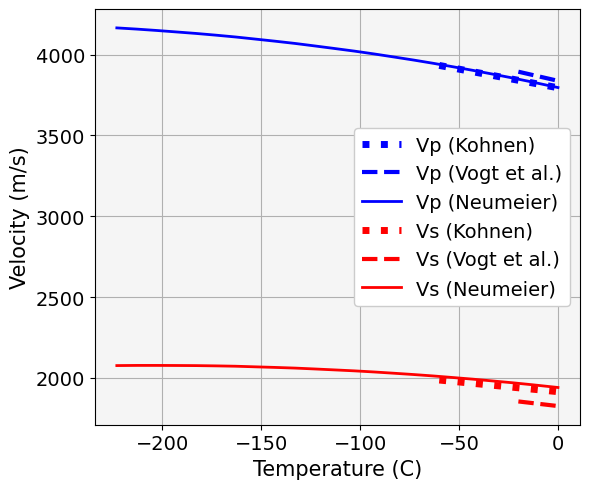

In [3]:
"""
Calculate effective mineral properties based on major 
mineral constituents of LHT-1g

Top 9 minerals were used from lab volume analysis,
representing 96.7% of total volume

k: bulk modulus, u: shear modulus
f: volume fraction, d: density
"""

## Keep this same order in the lists below
minerals = min_dict["minerals"]


## Gather mineral values into lists, use mineral order from above
min_volume_fractions = min_dict["min_volume_fractions"]
min_bulk_mods = min_dict["min_bulk_mods"]
min_shear_mods = min_dict["min_shear_mods"]
min_densities = min_dict["min_densities"]
min_pvels = [rp.p_vel_mod(k,u,d) for k,u,d in zip(min_bulk_mods, min_shear_mods, min_densities)]
min_svels = [rp.s_vel_mod(u,d) for u,d in zip(min_shear_mods, min_densities)]
min_vpvs = [p/s for p, s in zip(min_pvels, min_svels)]


## Calculate effective properties
## Note: difference between Hill Average and HS lower is minimal in this case
## Hill Average and HS average produce identical results
_kL, _uL = rp.hs_bound('lower', min_volume_fractions, min_bulk_mods, min_shear_mods)
_kU, _uU = rp.hs_bound('upper', min_volume_fractions, min_bulk_mods, min_shear_mods)
effective_mineral_k, effective_mineral_u = np.mean((_kL, _kU)), np.mean((_uL, _uU))
# eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])
eff_min_density = 2.98  ## override calculation w/ measured value
eff_min_vp = rp.p_vel_mod(effective_mineral_k, effective_mineral_u, eff_min_density)
eff_min_vs = rp.s_vel_mod(effective_mineral_u, eff_min_density)
eff_min_vpvs = eff_min_vp/eff_min_vs
poisson_grain = rp.poisson_mod(effective_mineral_k, effective_mineral_u)

#########################################
## Compare ice velocities presented in literature
## Calculate ice moduli at experimental temperature

def Pounder_ice_density(T):
    # from Pounder 1965, pg 114, expects temperature in C
    dens = 0.9168 * (1 - 1.53e-4 * T)
    return dens


## Velocity of ice reported by Vogt and Kohnen
temp_range_kohnen = np.arange(-60, 0, 1)
temp_range_vogt = np.arange(-20, 0, 1)
ice_vp_kohnen = [(-2.3*T + 3795) for T in temp_range_kohnen]  # from Kohnen 1974
ice_vs_kohnen = [(-1.2*T + 1915) for T in temp_range_kohnen]
ice_vp_vogt = [(3837.9 - 2.812*T) for T in temp_range_vogt]  # from Vogt 2008, used in Dou 2017
ice_vs_vogt = [(1826 - 1.425*T) for T in temp_range_vogt]

## Calculate velocity from elastic constants reported by Neumeier,
## using equations presented in Ledbetter 1977 (from Voight)
N_temp = ice_elastic_constants[:,0]
N_c11 = ice_elastic_constants[:,1]
N_c33 = ice_elastic_constants[:,2]
N_c12 = ice_elastic_constants[:,3]
N_c13 = ice_elastic_constants[:,4]
N_c44 = ice_elastic_constants[:,5]
N_c66 = 0.5*(N_c11-N_c12)  #"The Machanics of Ice", John Glen, similar to isotropic case where c66=c44

N_bulk = ((1/9) * (2*N_c11 + N_c33 + 2*N_c12 + 4*N_c13)) * 10
N_shear = ((1/15) * (2*N_c11 + N_c33 - N_c12 - 2*N_c13 + 6*N_c44 + 3*N_c66)) * 10

N_temp_C = N_temp-273
ice_density_range = Pounder_ice_density(N_temp_C)
N_vp = rp.p_vel_mod(N_bulk, N_shear, ice_density_range)*1000
N_vs = rp.s_vel_mod(N_shear, ice_density_range)*1000


fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax.plot(temp_range_kohnen, ice_vp_kohnen, color="blue", ls=":",lw="5", label="Vp (Kohnen)")
ax.plot(temp_range_vogt, ice_vp_vogt, color="blue", ls="--",lw="3", label="Vp (Vogt et al.)")
ax.plot(N_temp_C, N_vp, color="blue",lw="2", label="Vp (Neumeier)")

ax.plot(temp_range_kohnen, ice_vs_kohnen, color="red", ls=":",lw="5", label="Vs (Kohnen)")
ax.plot(temp_range_vogt, ice_vs_vogt, color="red", ls="--",lw="3", label="Vs (Vogt et al.)")
ax.plot(N_temp_C, N_vs, color="red",lw="2", label="Vs (Neumeier)")

ax.set(facecolor="whitesmoke",
      axisbelow=True,
      # xlim=(-125, 0))
      )
ax.set_xlabel("Temperature (C)", fontsize=15)
ax.set_ylabel("Velocity (m/s)", fontsize=15)
ax.tick_params(axis='both', labelsize=14)
ax.grid("both")
plt.legend(fontsize=14, framealpha=1)
plt.tight_layout()
plt.show()




ice_temp = -26  # in Celsius 
ice_dens = Pounder_ice_density(ice_temp)

## Fit Neumeier Bulk and Shear
k_fit = np.poly1d(np.polyfit(N_temp_C, N_bulk, deg=2))
u_fit = np.poly1d(np.polyfit(N_temp_C, N_shear, deg=2))

ice_k = k_fit(ice_temp)
ice_u = u_fit(ice_temp)

## Calculate moduli for grain-ice mixtures
icy_ks = []
icy_us = []
icy_dens = []
for i in ice_percs:
    v = [1-i, i]
    b = [effective_mineral_k, ice_k]
    u = [effective_mineral_u, ice_u]
    _kL, _uL = rp.hs_bound('lower', v, b, u)
    _kU, _uU = rp.hs_bound('upper', v, b, u)
    eff_k, eff_u = np.mean((_kL, _kU)), np.mean((_uL, _uU))
    d = sum([f*d for f, d in zip(v, [eff_min_density, ice_dens])])
    icy_ks.append(eff_k)
    icy_us.append(eff_u)
    icy_dens.append(d)

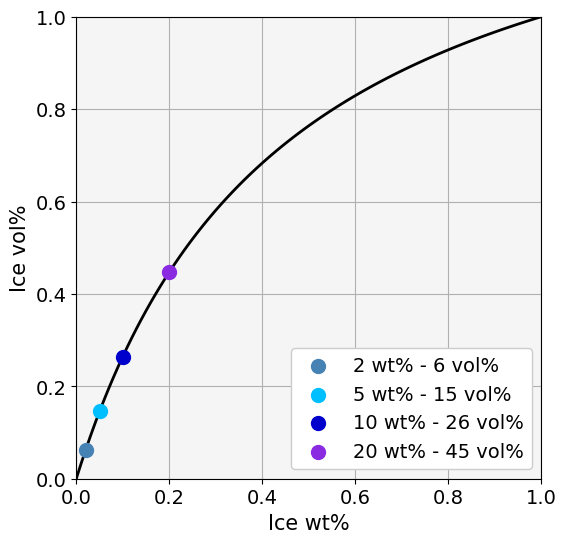

In [5]:
"""
Ice weight percent versus volume percent

All ices percents are treated as weight percent, however rock physics
models require volume percents
"""

wt_perc_ice = np.arange(0, 1.01, 0.01)
vol_perc_ice = (wt_perc_ice/ice_dens) / ((wt_perc_ice/ice_dens)+((1-wt_perc_ice)/eff_min_density))

plt.figure(figsize=(6,6))
dot_size=100
plt.plot(wt_perc_ice, vol_perc_ice, color="black", lw=2)
d0 = plt.scatter(ice_percs[0], vol_perc_ice[wt_perc_ice==ice_percs[0]], zorder=5, s=dot_size, color=ice_colors[0])
d1 = plt.scatter(ice_percs[1], vol_perc_ice[wt_perc_ice==ice_percs[1]], zorder=15, s=dot_size, color=ice_colors[1])
d2 = plt.scatter(ice_percs[2], vol_perc_ice[wt_perc_ice==ice_percs[2]], zorder=25, s=dot_size, color=ice_colors[2])
d3 = plt.scatter(ice_percs[3], vol_perc_ice[wt_perc_ice==ice_percs[3]], zorder=35, s=dot_size, color=ice_colors[3])
plt.xlabel("Ice wt%", fontsize=15)
plt.ylabel("Ice vol%", fontsize=15)
plt.gca().tick_params(axis='both', labelsize=14)
plt.gca().set(xlim=(0,1),
             ylim=(0,1),
             facecolor="whitesmoke")
l = plt.gca().legend([d0, d1, d2,d3], 
              ["2 wt% - 6 vol%",
              "5 wt% - 15 vol%",
              "10 wt% - 26 vol%",
              "20 wt% - 45 vol%"],
               handler_map={tuple: HandlerTuple(ndivide=None)}, 
              fontsize=14, framealpha=1, loc="lower right")
plt.grid("both")
plt.show()

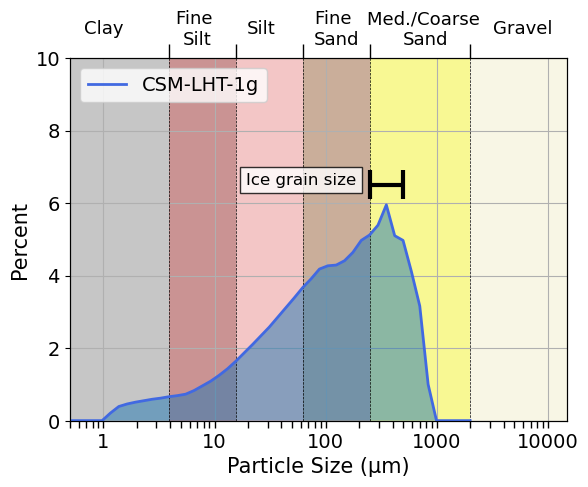

In [14]:
"""
Plot particle size distribution from LHT-1G and Ice Grains

Grain size classes shown are from the Wentworth (1922) scale.
"""

## LHT-1g
particle_sizes = particle_data[:,0]
particle_percents = particle_data[:,1]
particle_cumulative = particle_data[:,2]
particle_mean_bin = (np.abs(particle_cumulative - 50)).argmin()
particle_mean = particle_sizes[particle_mean_bin]



## From Wentworth scale, in microns
particle_boundaries=[3.9, 15.6, 63, 250, 2000, 20e3]

grain_colors = ["gray", "darkred", "lightcoral", "saddlebrown", "yellow", "lemonchiffon"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
# xlims=(2**-1, 12.5**3)
xlims=(5e-1, 15e3)
zorder = 5


## Percents bar plot
ax.plot(particle_sizes, particle_percents, color="royalblue", label="CSM-LHT-1g", linewidth=2, zorder=50)
ax.fill_between(particle_sizes, particle_percents, 0, alpha=0.5)
# bin_widths = np.pad(np.diff(particle_sizes), (0,1), mode="edge")
# bar_plot = ax[0].bar(particle_sizes, particle_percents, width=bin_widths, align="edge",
#       color="royalblue", edgecolor="black", zorder=zorder+3, label="CSM-LHT-1g")
# bar_plot[particle_mean_bin].set_color("lime")
# bar_plot[particle_mean_bin].set_edgecolor("black")
ax.set(xscale="log",
       ylim=(0, 10),
       xlim=(xlims[0], xlims[1]),
      axisbelow=True,
      facecolor="whitesmoke")
ax.set_xlabel("Particle Size (\u03BCm)", fontsize=15)
ax.set_ylabel("Percent", fontsize=15)
ax.grid(which="major")
for i, b in enumerate(particle_boundaries):
    if i==0:
        start = 0
    else:
        start = particle_boundaries[i-1]
    end = b
    ## Have to plot on `ax` to get behind bar chart
    ax.axvspan(start, end, color=grain_colors[i], alpha=0.4, zorder=-1, lw=0)
    if i != len(particle_boundaries)-1:
        ax.axvline(end, color="black", ls="--", lw=0.5)
# ax[0].xaxis.set_major_formatter(major_formatter1)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.get_xaxis().set_tick_params(which='both', size=5, width=1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc="upper left", fontsize=14)


## Grain size plot
sizeax0 = ax.twiny()
sizeax0.set(xlim=(xlims[0], xlims[1]),
          xscale="log")
sizeax0.set_xticks(ticks=particle_boundaries[:-1]) #NOTE: this MUST be called AFTER setting log scale
sizeax0.get_xaxis().set_tick_params(which='minor', size=0, width=0)
sizeax0.get_xaxis().set_tick_params(which='major', size=10, width=1)
sizeax0.text(1, 10.8, "Clay", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(7, 10.8, "Fine \nSilt", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(26, 10.8, "Silt", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(125, 10.8, "Fine \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(800, 10.8, "Med./Coarse \nSand", va="center", ha="center", rotation=0, fontsize=13)
sizeax0.text(6000, 10.8, "Gravel", va="center", ha="center", rotation=0, fontsize=13)

# ax[0].text(2e-1, 10.8, "a", ha="center", va="center", fontweight="bold", fontsize=15,
#           bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

## Ice grain size
ax.hlines(y=6.5, xmin=250, xmax=500, color="black", lw=3)
ax.vlines(x=250, ymin=6.1, ymax=6.9, color="black", lw=3)
ax.vlines(x=500, ymin=6.1, ymax=6.9, color="black", lw=3)
ax.text(60, 6.5, "Ice grain size", 
        bbox={"facecolor":"white", "alpha":0.8, "edgecolor":"black"},
       horizontalalignment='center', fontsize=12)




plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig1_grain_size.jpg", dpi=1000, bbox_inches = "tight")


## Modeling Constants

In [4]:
## Establish a few parameters here to keep organized

critical_porosity = 0.6  # 0.664 average from helium pyc, even higher on low-accuracy liquid pyc
fitting_por = 0.42  # fit porosity for max_poissons
max_poisson_list = [0.44, 0.426, 0.415, 0.409]  # Based on the observed average velocities
contact_ratios = [0.5, 0.9, 0.9, 0.9]  # for Bachrach HM
slip_percent = 0.5  # for Bachrach HM

## Rock Physics Modeling

C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


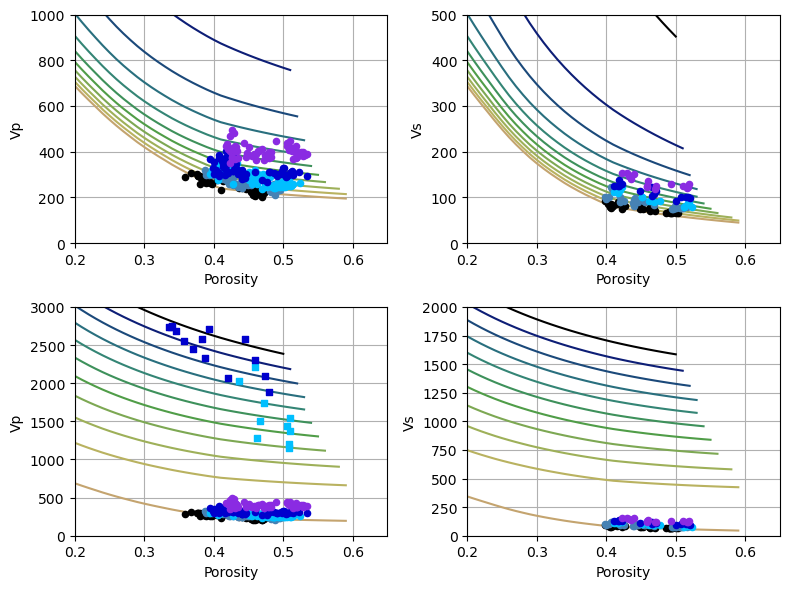

In [5]:
por_range = np.arange(0,critical_porosity, 0.01)
max_cement = 0.1
pressure = pressures[0]
contact_ratio = contact_ratios[0]
max_poisson = max_poisson_list[0]
C = 3

keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)

mixes = np.arange(0, 1.01, 0.1)
stiff_mixes_vp, stiff_mixes_vs = [], []
soft_mixes_vp, soft_mixes_vs = [], []

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
dot_size = 20
n_colors = len(mixes)
plot_colors = plt.cm.gist_earth_r(np.linspace(0.2,1,n_colors))

for m, mix_amount in enumerate(mixes):
    k_patchy, u_patchy, d_patchy = rp.patchy_ice_model(por=por_range, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain = eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=max_poisson,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="stiff", mix_amount=mix_amount)
    
    vp_patchy_stiff = rp.p_vel_mod(k_patchy, u_patchy, d_patchy)*1000
    vs_patchy_stiff = rp.s_vel_mod(u_patchy, d_patchy)*1000
    stiff_mixes_vp.append(vp_patchy_stiff)
    stiff_mixes_vs.append(vs_patchy_stiff)

    k_patchy, u_patchy, d_patchy = rp.patchy_ice_model(por=por_range, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, 
                         k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain = eff_min_density,
                         k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=max_poisson,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="soft", mix_amount=mix_amount)
    
    vp_patchy_soft = rp.p_vel_mod(k_patchy, u_patchy, d_patchy)*1000
    vs_patchy_soft = rp.s_vel_mod(u_patchy, d_patchy)*1000
    soft_mixes_vp.append(vp_patchy_soft)
    soft_mixes_vs.append(vs_patchy_soft)



    ## Soft Vp
    ax[0,0].plot(por_range[:len(vp_patchy_soft)], vp_patchy_soft, color=plot_colors[m])
    
    ## Soft Vs
    ax[0,1].plot(por_range[:len(vs_patchy_soft)], vs_patchy_soft, color=plot_colors[m])
    
    ## Stiff Vp
    ax[1,0].plot(por_range[:len(vp_patchy_stiff)], vp_patchy_stiff, color=plot_colors[m])
    
    ## Stiff Vs
    ax[1,1].plot(por_range[:len(vs_patchy_stiff)], vs_patchy_stiff, color=plot_colors[m])

## Plot data points
ax[0,0].scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s", zorder=50)
ax[0,0].scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size,  
              color=ice_colors[2], marker="s", zorder=50)
ax[0,0].scatter(data_p_0i[:,2], data_p_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[0,0].scatter(data_p_2i[:,2], data_p_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50)
ax[0,0].scatter(data_p_5i[:,2], data_p_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[0,0].scatter(data_p_10i[:,2], data_p_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[0,0].scatter(data_p_20i[:,2], data_p_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50)
ax[0,0].set_ylim(0,1000)
ax[0,0].set_xlim(0.2, 0.65)
ax[0,0].set_xlabel("Porosity")
ax[0,0].set_ylabel("Vp")
ax[0,0].grid("both")

ax[0,1].scatter(data_s_0i[:,2], data_s_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[0,1].scatter(data_s_2i[:,2], data_s_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50)
ax[0,1].scatter(data_s_5i[:,2], data_s_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[0,1].scatter(data_s_10i[:,2], data_s_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[0,1].scatter(data_s_20i[:,2], data_s_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50)
ax[0,1].set_ylim(0,500)
ax[0,1].set_xlim(0.2, 0.65)
ax[0,1].set_xlabel("Porosity")
ax[0,1].set_ylabel("Vs")
ax[0,1].grid("both")



ax[1,0].scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s", zorder=50)
ax[1,0].scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size,  
              color=ice_colors[2], marker="s", zorder=50)
ax[1,0].scatter(data_p_0i[:,2], data_p_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[1,0].scatter(data_p_2i[:,2], data_p_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50)
ax[1,0].scatter(data_p_5i[:,2], data_p_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[1,0].scatter(data_p_10i[:,2], data_p_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[1,0].scatter(data_p_20i[:,2], data_p_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50)
ax[1,0].set_ylim(0,3000)
ax[1,0].set_xlim(0.2, 0.65)
ax[1,0].set_xlabel("Porosity")
ax[1,0].set_ylabel("Vp")
ax[1,0].grid("both")

ax[1,1].scatter(data_s_0i[:,2], data_s_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[1,1].scatter(data_s_2i[:,2], data_s_2i[:,0], s=dot_size, color=ice_colors[0], zorder=50)
ax[1,1].scatter(data_s_5i[:,2], data_s_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[1,1].scatter(data_s_10i[:,2], data_s_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[1,1].scatter(data_s_20i[:,2], data_s_20i[:,0], s=dot_size, color=ice_colors[3], zorder=50)
ax[1,1].set_ylim(0,2000)
ax[1,1].set_xlim(0.2, 0.65)
ax[1,1].set_xlabel("Porosity")
ax[1,1].set_ylabel("Vs")
ax[1,1].grid("both")

plt.tight_layout()
plt.show()

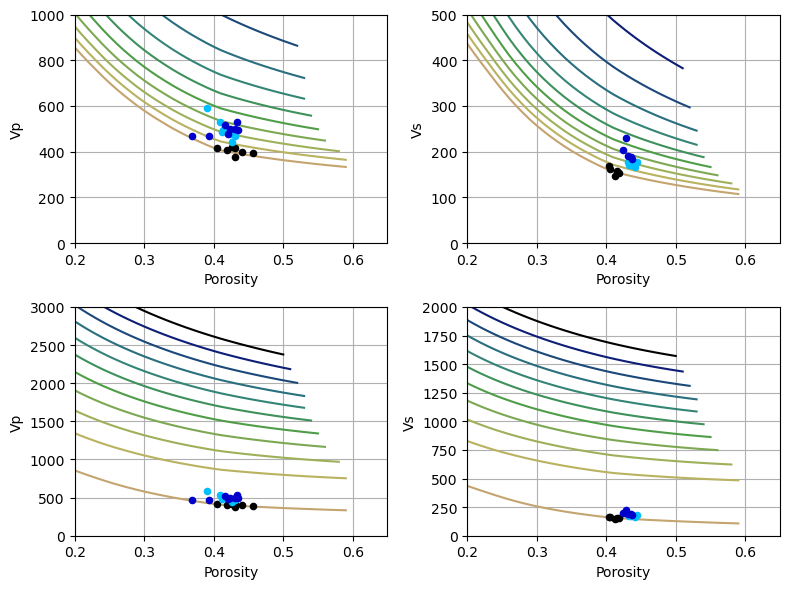

In [45]:
## pressure modeling with patchy ice model

por_range = np.arange(0,critical_porosity, 0.01)
max_cement = 0.1
pressure = pressures[2]
contact_ratio = contact_ratios[2]
max_poisson = max_poisson_list[2]
C = 3

keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)

mixes = np.arange(0, 1.01, 0.1)
stiff_mixes_vp, stiff_mixes_vs = [], []
soft_mixes_vp, soft_mixes_vs = [], []

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
dot_size = 20
n_colors = len(mixes)
plot_colors = plt.cm.gist_earth_r(np.linspace(0.2,1,n_colors))

for m, mix_amount in enumerate(mixes):
    k_patchy, u_patchy, d_patchy = patchy_ice_model(por=por_range, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, k_grain=effective_mineral_k, mu_grain=effective_mineral_u, 
                                          k_ice=ice_k, u_ice=ice_u,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=max_poisson,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="stiff", mix_amount=mix_amount)
    
    vp_patchy_stiff = rp.p_vel_mod(k_patchy, u_patchy, d_patchy)*1000
    vs_patchy_stiff = rp.s_vel_mod(u_patchy, d_patchy)*1000
    stiff_mixes_vp.append(vp_patchy_stiff)
    stiff_mixes_vs.append(vs_patchy_stiff)

    k_patchy, u_patchy, d_patchy = patchy_ice_model(por=por_range, crit_por=critical_porosity, C=C, 
                         keff=keff, ueff=ueff, k_grain=effective_mineral_k, mu_grain=effective_mineral_u, 
                                          k_ice=ice_k, u_ice=ice_u,
                         fit_por=fitting_por, trans_por=0.41, max_poisson=max_poisson,
                         contact_scheme="contact", max_cement=max_cement,
                         patchy_scheme="soft", mix_amount=mix_amount)
    
    vp_patchy_soft = rp.p_vel_mod(k_patchy, u_patchy, d_patchy)*1000
    vs_patchy_soft = rp.s_vel_mod(u_patchy, d_patchy)*1000
    soft_mixes_vp.append(vp_patchy_soft)
    soft_mixes_vs.append(vs_patchy_soft)



    ## Soft Vp
    ax[0,0].plot(por_range[:len(vp_patchy_soft)], vp_patchy_soft, color=plot_colors[m])
    
    ## Soft Vs
    ax[0,1].plot(por_range[:len(vs_patchy_soft)], vs_patchy_soft, color=plot_colors[m])
    
    ## Stiff Vp
    ax[1,0].plot(por_range[:len(vp_patchy_stiff)], vp_patchy_stiff, color=plot_colors[m])
    
    ## Stiff Vs
    ax[1,1].plot(por_range[:len(vs_patchy_stiff)], vs_patchy_stiff, color=plot_colors[m])

## Plot data points
ax[0,0].scatter(pres_step_2_p_0i[:,2], pres_step_2_p_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[0,0].scatter(pres_step_2_p_5i[:,2], pres_step_2_p_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[0,0].scatter(pres_step_2_p_10i[:,2], pres_step_2_p_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[0,0].set_ylim(0,1000)
ax[0,0].set_xlim(0.2, 0.65)
ax[0,0].set_xlabel("Porosity")
ax[0,0].set_ylabel("Vp")
ax[0,0].grid("both")

ax[0,1].scatter(pres_step_2_s_0i[:,2], pres_step_2_s_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[0,1].scatter(pres_step_2_s_5i[:,2], pres_step_2_s_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[0,1].scatter(pres_step_2_s_10i[:,2], pres_step_2_s_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[0,1].set_ylim(0,500)
ax[0,1].set_xlim(0.2, 0.65)
ax[0,1].set_xlabel("Porosity")
ax[0,1].set_ylabel("Vs")
ax[0,1].grid("both")



ax[1,0].scatter(pres_step_2_p_0i[:,2], pres_step_2_p_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[1,0].scatter(pres_step_2_p_5i[:,2], pres_step_2_p_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[1,0].scatter(pres_step_2_p_10i[:,2], pres_step_2_p_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[1,0].set_ylim(0,3000)
ax[1,0].set_xlim(0.2, 0.65)
ax[1,0].set_xlabel("Porosity")
ax[1,0].set_ylabel("Vp")
ax[1,0].grid("both")

ax[1,1].scatter(pres_step_2_s_0i[:,2], pres_step_2_s_0i[:,0], s=dot_size,  color="black", zorder=50)
ax[1,1].scatter(pres_step_2_s_5i[:,2], pres_step_2_s_5i[:,0], s=dot_size, color=ice_colors[1], zorder=50)
ax[1,1].scatter(pres_step_2_s_10i[:,2], pres_step_2_s_10i[:,0], s=dot_size, color=ice_colors[2], zorder=50)
ax[1,1].set_ylim(0,2000)
ax[1,1].set_xlim(0.2, 0.65)
ax[1,1].set_xlabel("Porosity")
ax[1,1].set_ylabel("Vs")
ax[1,1].grid("both")

plt.tight_layout()
plt.show()

# OLD

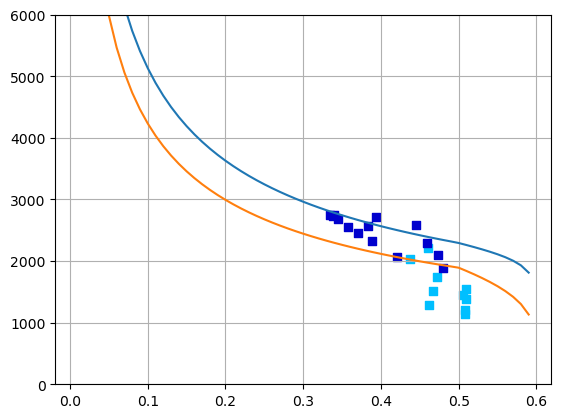

In [4]:
# ## effective mineral moduli with 10% ice
# icy_eff_min_k = rp.hill_average([0.9, 0.1], [effective_mineral_k, ice_k])
# icy_eff_min_u = rp.hill_average([0.9, 0.1], [effective_mineral_u, ice_u])

cement = 0.1
critical_por = 0.6


## moduli at transition from cementing to pore filling
# trans_k, trans_u = rp.cemented_model(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   por=critical_por-cement, crit_por=critical_por, C = rp.upper_murphy(critical_por-cement), scheme="uniform")


# ## use lower HS to calculate pore filling moduli, followed by cemented model
# por_range = np.arange(0,critical_por+0.01, 0.01)
# k_range, u_range = [], []
# pvels = []
# for por in por_range:
#     if por < (critical_por-cement):
#         k, u = rp.uncemented_model(por, critical_por-cement, trans_k, trans_u, icy_eff_min_k, icy_eff_min_u)
#         k_range.append(k)
#         u_range.append(u)
#     else:
#         k, u = rp.cemented_model(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   por, crit_por=critical_por, C=rp.upper_murphy(por), scheme="uniform")
#         k_range.append(k)
#         u_range.append(u)

#     pvels.append(rp.p_vel_mod(k, u, eff_min_density)*1000)


# plt.figure()
# plt.plot(por_range, pvels)
# plt.grid("both")
# # plt.ylim(0, 3000)
# plt.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", 
#               color=ice_colors[1], marker="s")
# plt.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", 
#               color=ice_colors[2], marker="s")
# plt.show()



# cem_k, cem_u = [], []
# for por in por_range:
#     k, u = rp.cemented_model(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   por, crit_por=0.6, C=3, scheme="contact")
#     cem_k.append(k)
#     cem_u.append(u)

# plt.figure()
# plt.plot(por_range, cem_k)
# plt.plot(por_range, cem_u)
# plt.show()



k_sccem, u_sccem, por_sccem = rp.self_consistent_contact_cement(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
                  por=critical_por-cement, crit_por=critical_por, C=3, scheme="contact")
k_sccem_uni, u_sccem_uni, por_sccem_uni = rp.self_consistent_contact_cement(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
                  por=critical_por-cement, crit_por=critical_por, C=3, scheme="uniform")
# k_sccem, u_sccem, por_sccem = rp.self_consistent_contact_cement_SYM(ice_k, ice_u, effective_mineral_k, effective_mineral_u, 
#                   critical_por-cement, critical_por, C=5, scheme="contact")

vp_sccem = rp.p_vel_mod(k_sccem, u_sccem, eff_min_density*por_sccem)*1000
vs_sccem = rp.s_vel_mod(u_sccem, eff_min_density*por_sccem)*1000

vp_sccem_uni = rp.p_vel_mod(k_sccem_uni, u_sccem_uni, eff_min_density*por_sccem_uni)*1000

plt.figure()
plt.plot(por_sccem, vp_sccem)
plt.plot(por_sccem_uni, vp_sccem_uni)
# plt.plot(por_sccem, vs_sccem)
dot_size = 30
plt.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size, label=str(round(ice_percs[1]*100))+"% ice", 
              color=ice_colors[1], marker="s")
plt.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, label=str(round(ice_percs[2]*100))+"% ice", 
              color=ice_colors[2], marker="s")
plt.ylim(0, 6000)
plt.grid("both")
plt.show()

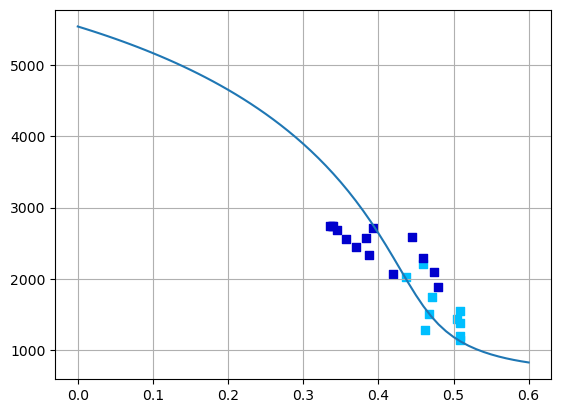

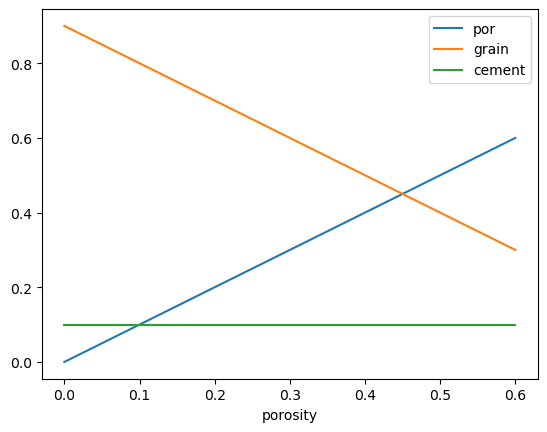

In [38]:
"""
berryman tests
"""
#-------------------------------------
## functions
from sympy import symbols, Eq, solve, nsolve, solveset, S
def z_var(k, u):
    z = (u*(9*k + 8*u)) / (6*(k + 2*u))
    return z
def b_var(k,u):
    b = u * ((3*k + u)/(3*k + 4*u))
    return b
def q_var(ki, ui, km, um, shape, aspect_ratio):
    if shape.lower()=='spheres':
        q = (um + z_var(km, um)) / (ui + z_var(km, um))
    if shape.lower()=='disks':
        q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))
    if shape.lower()=='penny cracks':
        q = (1/5) * (1 + (8*um / (4*ui + np.pi*aspect_ratio*(um + 2*b_var(km, um)))) + \
                     2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*aspect_ratio*b_var(km, um))))
    return q
def p_var(ki, ui, km, um, shape, aspect_ratio):
    
    if shape.lower()=='spheres':
        p = (km + (4/3)*um) / (ki + (4/3)*um)
    if shape.lower()=='disks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui)
    if shape.lower()=='penny cracks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*aspect_ratio*b_var(km, um))
    return p



#-------------------------------------



k_list = [effective_mineral_k, ice_k, 0.]
mu_list = [effective_mineral_u, ice_u, 0.]
# vol_fracts = [0.45, 0.05, 0.5]
# vol_fracts = [0.55, 0.1, 0.35]
# vol_fracts = [0.55, 0.45, 0.]
inclusion_shapes = ["spheres", "disks", "spheres"]
crack_aspect_ratios = [1, 1e-2, 1]

critical_porosity = 0.6
cement = 0.1
por_range = np.arange(0, critical_porosity+0.01, 0.01)
grain_range = np.arange(1, 1-(critical_porosity+0.01), -0.01) - cement
cem_range = np.array([cement]*len(grain_range)) 

vp_sc, vs_sc = [], []

for i in range(len(por_range)):
    v_grain = grain_range[i]
    v_por = por_range[i]
    v_ice = cem_range[i]
    vol_fracts = [v_grain, v_ice, v_por]

    ksc, usc = symbols('ksc usc', positive=True, real=True)
    k_start = k_list[0]*vol_fracts[0]
    u_start = mu_list[0]*vol_fracts[0]
    
    eqk = Eq((
        (vol_fracts[0] * (k_list[0] - ksc) * p_var(k_list[0], mu_list[0], ksc, usc, 
                                                   inclusion_shapes[0], crack_aspect_ratios[0]))+
        (vol_fracts[1] * (k_list[1] - ksc) * p_var(k_list[1], mu_list[1], ksc, usc, 
                                                   inclusion_shapes[1], crack_aspect_ratios[1]))+
        (vol_fracts[2] * (k_list[2] - ksc) * p_var(k_list[2], mu_list[2], ksc, usc, 
                                                   inclusion_shapes[2], crack_aspect_ratios[2]))),0)
    equ = Eq((
        (vol_fracts[0] * (mu_list[0] - usc) * q_var(k_list[0], mu_list[0], ksc, usc, 
                                                   inclusion_shapes[0], crack_aspect_ratios[0]))+
        (vol_fracts[1] * (mu_list[1] - usc) * q_var(k_list[1], mu_list[1], ksc, usc, 
                                                   inclusion_shapes[1], crack_aspect_ratios[1]))+
        (vol_fracts[2] * (mu_list[2] - usc) * q_var(k_list[2], mu_list[2], ksc, usc, 
                                                   inclusion_shapes[2], crack_aspect_ratios[2]))),0)

    iter_solve_k, iter_solve_u = nsolve((eqk, equ), (ksc, usc), (k_start, u_start))
    tmp_vp = rp.p_vel_mod(iter_solve_k, iter_solve_u, eff_min_density*(1-v_por))*1000
    tmp_vs = rp.s_vel_mod(iter_solve_u, eff_min_density*(1-v_por))*1000
    vp_sc.append(tmp_vp)
    vs_sc.append(tmp_vs)


# iter_solve_k, iter_solve_u = nsolve((eqk, equ), (ksc, usc), (k_start, u_start))
# print(iter_solve_k, iter_solve_u)
# p_vel = rp.p_vel_mod(iter_solve_k, iter_solve_u, eff_min_density*0.6)
# print("Spheres P vel: ", round(p_vel*1000))

dot_size=30
plt.plot(por_range, vp_sc)
plt.scatter(data_p_5i_cem[:,2], data_p_5i_cem[:,0], s=dot_size,  
              color=ice_colors[1], marker="s")
plt.scatter(data_p_10i_cem[:,2], data_p_10i_cem[:,0], s=dot_size, 
              color=ice_colors[2], marker="s")
plt.grid("both")
plt.show()



plt.plot(por_range, por_range, label="por")
plt.plot(por_range, grain_range, label="grain")
plt.plot(por_range, cem_range, label="cement")
plt.legend()
plt.xlabel("porosity")
plt.show()

In [53]:
def berryman_sca(k_list, mu_list, vol_fracts, inclusion_shapes,
                  crack_aspect_ratios=[]):

    assert len(k_list)==len(mu_list)==len(vol_fracts)==len(inclusion_shapes),\
        "Length of input variables is not consistent"

    allowable_inclusions = ['spheres', 'disks', 'penny cracks']
    inclusion_shapes = [i.lower() for i in inclusion_shapes]
    for i in inclusion_shapes:
        assert i in allowable_inclusions, "Inclusion shape not supported"

    if "penny cracks" in inclusion_shapes:
        assert len(crack_aspect_ratios) != 0, "Penny cracks must include aspect ratio"
        # crack_count = inclusion_shapes.lower().count("penny cracks")
        # assert len(crack_aspect_ratios)==len(k_list) or len(crack_aspect_ratios)==crack_count,\
        #     "Check aspect ratios: Penny cracks must include aspect ratio"
        assert len(crack_aspect_ratios)==len(k_list), \
            "If providing penny cracks, use aspect ratio of 1 or np.nan for non-cracks"

    ## create dummy list even if no penny cracks
    if "penny cracks" not in inclusion_shapes:
        crack_aspect_ratios = [1] * len(k_list)


    ## Helper functions for P and Q coefficients
    ## RP handbook, page 187
    def z_var(k, u):
        z = (u*(9*k + 8*u)) / (6*(k + 2*u))
        return z
    
    def b_var(k,u):
        b = u * ((3*k + u)/(3*k + 4*u))
        return b

    def q_var(ki, ui, km, um, shape, aspect_ratio):
        
        if shape.lower()=='spheres':
            q = (um + z_var(km, um)) / (ui + z_var(km, um))
        if shape.lower()=='disks':
            q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))
        if shape.lower()=='penny cracks':
            q = (1/5) * (1 + (8*um / (4*ui + np.pi*aspect_ratio*(um + 2*b_var(km, um)))) + \
                         2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*aspect_ratio*b_var(km, um))))
        return q

    def p_var(ki, ui, km, um, shape, aspect_ratio):
        
        if shape.lower()=='spheres':
            p = (km + (4/3)*um) / (ki + (4/3)*um)
        if shape.lower()=='disks':
            p = (km + (4/3)*ui) / (ki + (4/3)*ui)
        if shape.lower()=='penny cracks':
            p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*aspect_ratio*b_var(km, um))
        return p
    

    ## Calculate starting point using Voight average
    kvoight = rp.voight_average(vol_fracts, k_list)
    uvoight = rp.voight_average(vol_fracts, mu_list)
    kreuss = rp.reuss_average(vol_fracts, k_list)
    ureuss = rp.reuss_average(vol_fracts, mu_list)
    # ksc, usc = kvoight, uvoight
    # ksc, usc = k_list[0]*vol_fracts[0], mu_list[0]*vol_fracts[0]
    ksc, usc = k_list[0], mu_list[0]
    kold, uold = 0, 0

    ## set the error tolerance
    # err_tolerance = 1e-6*k_list[0]
    err_tolerance = 1e-4*k_list[0]



    plt_k, plt_u = [], []

    

    iter_count=0
    while np.abs(ksc-kold)>err_tolerance: 
        # while (np.abs(ksc-kold)>err_tolerance) and (np.abs(usc-uold)>err_tolerance): 
        kold = ksc
        uold = usc

        p_vars = []
        for k, u, shape, aspect_ratio in zip(k_list, mu_list, inclusion_shapes, crack_aspect_ratios):
            tmp_p = p_var(k, u, ksc, usc, shape, aspect_ratio)
            p_vars.append(tmp_p)
        q_vars = []
        for k, u, shape, aspect_ratio in zip(k_list, mu_list, inclusion_shapes, crack_aspect_ratios):
            tmp_q = q_var(k, u, ksc, usc, shape, aspect_ratio)
            q_vars.append(tmp_q)

        ## i don't know what to do here
        ## the "denom" is following stanford matlab code
        k_tmp = []
        k_denom = []
        for i in range(len(vol_fracts)):
            _k = vol_fracts[i] * (k_list[i] - ksc) * p_vars[i]
            k_tmp.append(_k)
            _kd = vol_fracts[i]* p_vars[i]
            k_denom.append(_kd)
        u_tmp = []
        u_denom = []
        for i in range(len(vol_fracts)):
            _u = vol_fracts[i] * (mu_list[i] - usc) * q_vars[i]
            u_tmp.append(_u)
            _ud = vol_fracts[i] * q_vars[i]
            u_denom.append(_ud)

        # ksc = ksc - np.sum(k_tmp)
        # usc = usc - np.sum(u_tmp)
        ksc = np.sum(k_tmp) / np.sum(k_denom)
        usc = np.sum(u_tmp) / np.sum(u_denom)

        if ksc > max(kvoight, kreuss):
            ksc = max(kvoight, kreuss)
        if ksc < min(kvoight, kreuss):
            ksc = min(kvoight, kreuss)
        if usc > max(uvoight, ureuss):
            usc = max(uvoight, ureuss)
        if usc < min(uvoight, ureuss):
            usc = min(uvoight, ureuss)



        plt_k.append(ksc)
        plt_u.append(usc)

        

        
        ## kill process if iterations don't converge after set number
        iter_count+=1
        if iter_count == 10000:


            plt.plot(np.arange(iter_count), plt_k, label="k")
            plt.plot(np.arange(iter_count), plt_u, label="u")
            plt.legend()
            plt.show()

            
            # sys.stdout.write("Berryman SCA could not converge")
            print("Berryman SCA could not converge")
            return
    
    
    # print(iter_count)
    plt.plot(np.arange(iter_count), plt_k, label="k")
    plt.plot(np.arange(iter_count), plt_u, label="u")
    plt.legend()
    plt.show()



    
    return ksc, usc



k_list = [37, 2.25, 2.25]
mu_list = [44, 0., 0.]
vol_fracts = [0.7, 0.29, 0.01]
inclusion_shapes = ["spheres", "spheres", "penny cracks"]
crack_aspect_ratios = [1, 1, 10e-2]


# k_list = [37, 0]
# mu_list = [44, 0]
# vol_fracts = [0.7, 0.3]
# inclusion_shapes = ["spheres", "spheres"]

k, u = berryman_sca(k_list, mu_list, vol_fracts, inclusion_shapes, crack_aspect_ratios)
print(k, u)

ZeroDivisionError: float division by zero